# Görüntü Sınıflandırma için Derin Sinir Ağı: Uygulama

## 1 - Modüller

önce uygulama sırasında ihtiyaç duyacağınız tüm paketleri içe aktaralım.
- [numpy](https://www.numpy.org/) Python ile bilimsel hesaplama için temel pakettir.
- [matplotlib](http://matplotlib.org) Python'daki grafikleri çizmek için kullanılan bir kütüphanedir.
- [h5py](http://www.h5py.org) H5 dosyasında depolanan bir veri kümesiyle etkileşim kurmak için kullanılan ortak bir pakettir.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) burada modelinizi sonunda kendi resminizle test etmek için kullanılıyor.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Veri seti

Kedi ve Kedi Olmayan veri kümesini kullanacağız. Yaptığınız model, kedileri kedi olmayan görüntülere göre sınıflandırırken% 70 test doğruluğuna sahipti. Umarım, yeni modeliniz daha iyi bir performans sergiler!

Size aşağıdakileri içeren bir veri kümesi ("data.h5") verilir:

   - kedi (1) veya kedi olmayan (0) olarak etiketlenmiş bir m_train görüntüsü eğitim seti
    
   - kedi ve kedi olmayan olarak etiketlenmiş m_test görüntülerinin test seti
    
   - her resim 3 (3) kanalı (RGB) için olan şekildedir (num_px, num_px, 3).
    

Veri kümesini daha yakından tanıyalım. Aşağıdaki hücreyi çalıştırarak verileri yükleyin.



In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

Aşağıdaki kod, veri kümesinde bir resim gösterecektir. Dizini değiştirmek ve diğer görüntüleri görmek için hücreyi birkaç kez yeniden çalıştırmaktan çekinmeyin.

y = 0. It's a non-cat picture.


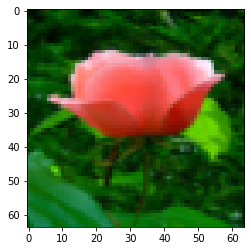

In [3]:
# Resim örneği
index = 3
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# veri kümemizi keşfedelim.
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Her zamanki gibi, görüntüleri ağa beslemeden önce yeniden şekillendirir ve standartlaştırırsınız.
<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [5]:
# Eğitimi ve test örneklerini yeniden şekillendirin

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T  # "-1", yeniden boyutlandırmayı kalan boyutları düzleştirir
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# 0 ile 1 arasında özellik değerleri elde etmek için verileri standartlaştırın.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

# 64*64*3

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 3 - Modelinizin mimarisi

Artık veri kümesine aşina olduğunuza göre, kedi görüntülerini kedi olmayan görüntülerden ayırt etmek için derin bir sinir ağı oluşturma zamanı.

İki farklı model oluşturacaksınız:
- 2 katmanlı bir sinir ağı
- L tabakalı derin sinir ağı

Daha sonra bu modellerin performansını karşılaştıracak ve $ L $ için farklı değerler deneyeceksiniz.

İki mimariye bakalım.

### 3.1 - 2 Katmanlı Sinir Ağı

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2 katmanlı sinir ağı. <br> Model şu şekilde özetlenebilir: *** INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT ***. </center></caption>

<u> Şekil 2'nin Ayrıntılı Mimarisi </u>:

- Girdi, $ (12288,1) $ boyutunda bir vektöre düzleştirilen (64,64,3) bir resimdir.

- Karşılık gelen vektör: $ [x_0, x_1, ..., x_ {12287}] ^ T $ daha sonra $ W ^ {[1]} $ boyutunda $ (n ^ {[1]} ağırlık matrisi ile çarpılır. 12288).

- Daha sonra bir önyargı terimi ekler ve şu vektörü elde etmek için relu değerini alırsınız: $ [a_0 ^ {[1]}, a_1 ^ {[1]}, ..., a_ {n ^ {[1]} - 1 } ^ {[1]}] ^ T $.

- Daha sonra aynı işlemi tekrarlarsınız.

- Elde edilen vektörü $ W ^ {[2]} $ ile çarpar ve kesişiminizi (sapma) eklersiniz.

- Sonunda, sonucun sigmoidini alıyorsunuz. 0,5'ten büyükse, onu bir kedi olarak sınıflandırırsınız.



### 3.2 - L Tabakalı Derin Sinir Ağı

Yukarıdaki temsili bir L tabakalı derin sinir ağını temsil etmek zordur. Ancak, burada basitleştirilmiş bir ağ temsili verilmiştir:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-katman sinir ağı. <br> Model şu şekilde özetlenebilir: *** [LINEAR -> RELU] $ \ times $ (L-1) -> LINEAR -> SIGMOID***</center></caption>


<u> Şekil 3'ün Ayrıntılı Mimarisi </u>:

- Giriş, (12288,1) boyutunda bir vektöre düzleştirilen (64,64,3) bir görüntüdür.
- Karşılık gelen vektör: $ [x_0, x_1, ..., x_ {12287}] ^ T $ daha sonra $ W ^ {[1]} $ agirlik matrisi ile carpilir ve ardindan $ b ^ {[ 1]} $. Sonuc dogrusal birim olarak adlandirilir.

- Sonra, dogrusal birimin relu'yu alirsiniz. Bu islem, model mimarisine bagli olarak her $ (W ^ {[l]}, b ^ {[l]}) $ icin birkac kez tekrarlanabilir.

- Son olarak, son lineer unitenin sigmoidini alirsiniz. 0,5'ten buyukse, onu bir kedi olarak siniflandirirsiniz.

### 3.3 - Genel metodoloji

Her zamanki gibi, modeli oluşturmak için Derin Öğrenme metodolojisini takip edeceksiniz:
    1. Parametreleri başlat / Hiperparametreleri tanımla
    2. Num_iterations için döngü:
        a. İleri yayılma
        b. Hesaplama maliyet fonksiyonu
        c. Geriye doğru yayılma
        d. Parametreleri güncelleme (backprop parametrelerini ve gradlarını kullanarak)
    4. Etiketleri tahmin etmek için eğitimli parametreleri kullanın

Şimdi bu iki modeli uygulayalım!

## 4 - İki katmanlı sinir ağı

```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### MODELİ TANIMLAMAK İÇİN SABİTLER ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
# KADEMELİ FONKSİYON: iki katmanlı model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    İki katmanlı bir sinir ağı uygular: LINEAR-> RELU-> LINEAR-> SIGMOID.
    
    Argümanlar:
    X - giriş verileri, şekil (n_x, örnek sayısı)
    Y - gerçek "etiket" vektörü (kedi ise 0, kedi değilse 1), şekil (1, örnek sayısı)
    layers_dims - katmanların boyutları (n_x, n_h, n_y)
    num_iterations - optimizasyon döngüsünün yineleme sayısı
    learning_rate - degrade iniş güncelleme kuralının öğrenme oranı
    print_cost - True olarak ayarlanırsa, maliyet her 100 yinelemede bir yazdırılır
    
    İadeler:
    parametreleri - W1, W2, b1 ve b2 içeren bir sözlük
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                             # maliyeti takip etmek
    m = X.shape[1]                           # eğitim örenek sayısı
    (n_x, n_h, n_y) = layers_dims
    
    # Daha önce uyguladığınız işlevlerden birini çağırarak parametre sözlüğünü başlatın

    parameters = initialize_parameters(n_x, n_h, n_y)

    
    # Sözlük parametrelerinden W1, b1, W2 ve b2'yi alın.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # döngü

    for i in range(0, num_iterations):

        # İleri yayılma: LINEAR -> RELU -> LINEAR -> SIGMOID. Girişler: "X, W1, b1, W2, b2". Çıktı: "A1, önbellek1, A2, önbellek2".


        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        
        # maliyet
        cost = compute_cost(A2, Y)

        
        # Geriye doğru yayılmayı başlatma
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Geriye doğru yayılma. Girişler: "dA2, cache2, cache1". Çıktılar: "dA1, dW2, db2; ayrıca dA0 (kullanılmaz), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        
        # Gradları ['dWl'] dW1'e, gradları ['db1'] db1'e, ​​['dW2'] gradlarını dW2'ye, grad ['db2'] değerini db2'ye ayarlayın
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # parametreleri güncelleme
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # W1 = W1 * (alfa) * learning_rate
        
        # parametreleri sözlükten geri alma
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Her 100 eğitim örneğinde maliyeti yazdırın
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # maliyeti çiz

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Parametrelerinizi eğitmek için aşağıdaki hücreyi çalıştırın. Modelinizin çalışıp çalışmadığına bakın. Maliyet düşüyor olmalı. 2500 yineleme çalıştırmak 5 dakika kadar sürebilir. "Yineleme 0 sonrası maliyet" in aşağıdaki beklenen çıktıyla eşleşip eşleşmediğini kontrol edin, eğer değilse hücreyi durdurmak ve hatanızı bulmaya çalışmak için dizüstü bilgisayarın üst çubuğundaki kareye (⬛) tıklayın.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.27491377282130197
Cost after iteration 1300: 0.24681768210614827
Cost after iteration 1400: 0.19850735037466088
Cost after iteration 1500: 0.1744831811255664
Cost after iteration 1600: 0.17080762978095726
Cost after iteration 1700: 0.11306524562164744
Cost after iteration 1800: 0.09629426845937158
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319077
Cost after iteration 2100: 0.06630748132

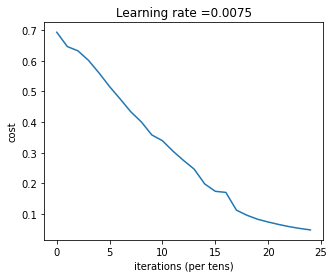

In [8]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

İyi bir şey, vektörize bir uygulama oluşturdunuz! Aksi takdirde bunu eğitmek 10 kat daha uzun sürebilir.

Artık, veri kümesindeki görüntüleri sınıflandırmak için eğitilmiş parametreleri kullanabilirsiniz. Eğitim ve test setleri hakkındaki tahminlerinizi görmek için aşağıdaki hücreyi çalıştırın.

In [9]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [10]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Expected Output**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

## 5 - L-katmanlı Sinir Ağı

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```


In [11]:
### SABİT ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [12]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Bir L-katman sinir ağı uygular: [LINEAR-> RELU] * (L-1) -> LINEAR-> SIGMOID.
    
    Argümanlar:
    X - veri, numpy şekil dizisi (örnek sayısı, num_px * num_px * 3)
    Y - gerçek "etiket" vektörü (kedi ise 0, kedi değilse 1), şekil (1, örnek sayısı)
    layers_dims - giriş boyutunu ve her bir katman boyutunu, uzunluk (liste sayısı + 1) içeren liste.
    learning_rate - degrade iniş güncelleme kuralının öğrenme oranı
    num_iterations - optimizasyon döngüsünün yineleme sayısı
    print_cost - True ise, maliyeti her 100 adımda bir yazdırır
    
    İadeler:
    parametreler - model tarafından öğrenilen parametreler. Daha sonra tahmin etmek için kullanılabilirler.
    """



    np.random.seed(1)
    costs = []                        # maliyeti takip edin
    
    # Parametrelerin başlatılması.
    parameters = initialize_parameters_deep(layers_dims)

    
    # Döngü
    for i in range(0, num_iterations):

        # İleri yayılma: [LINEAR -> RELU] * (L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # maliyet
        cost = compute_cost(AL, Y)
    
        # Geriye yayılım.
        grads = L_model_backward(AL, Y, caches)
 
        # Parametre güncelleme
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Her 100 eğitim örneğinde maliyeti yazdırın
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # maliyeti çizme
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Şimdi modeli 4 katmanlı bir sinir ağı olarak eğiteceksiniz.

Modelinizi eğitmek için aşağıdaki hücreyi çalıştırın. Her yinelemede maliyet düşmelidir. 2500 yineleme çalıştırmak 5 dakika kadar sürebilir. "Yineleme 0 sonrası maliyet" in aşağıdaki beklenen çıktıyla eşleşip eşleşmediğini kontrol edin, eğer değilse hücreyi durdurmak ve hatanızı bulmaya çalışmak için dizüstü bilgisayarın üst çubuğundaki kareye (⬛) tıklayın.

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


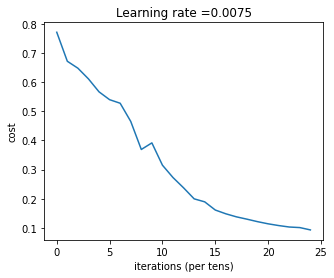

In [13]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [14]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [15]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Expected Output**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

Tebrikler! 4 katmanlı sinir ağınızın aynı test setindeki 2 katmanlı sinir ağınızdan (% 72) daha iyi performansa (% 80) sahip olduğu görülmektedir.

Bu, bu görev için iyi bir performans. İyi iş!

##  6) Sonuç Analizi

İlk olarak, L katmanlı modelin yanlış etiketlenmiş bazı resimlerine bakalım. Bu, birkaç yanlış etiketlenmiş görüntüyü gösterecektir.

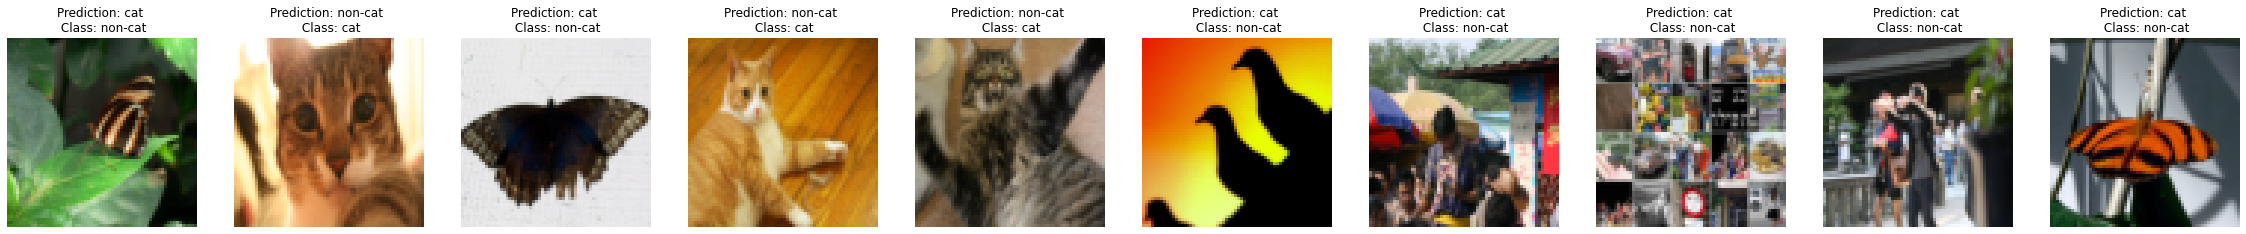

In [16]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

** Modelin kötü performans gösterdiği birkaç resim türü şunları içerir: **
- Alışılmadık bir pozisyonda kedi gövdesi
- Kedi benzer renkte bir arka plana karşı görünür
- Olağandışı kedi rengi ve türü
- Kamera açısı
- Resmin parlaklığı
- Ölçek değişimi (kedi görüntüde çok büyük veya küçük)